# `dctrack`: A Python library to track cells in rtdc files

This notebook gives an example how to use the python library `dctrack` that was created to track the movement of cells through different channel geometries, measured with the software Shape-In 2.

To use the `dctrack` library and this notebook properly, please download the source code under https://gitlab.gwdg.de/freiche/rtdc_tracking2.0 and then navigate in the console to the directory `rtdc_tracking2.0` and install the dctrack package using `python -m pip install dctrack`.

In [1]:
import dclab
import dctrack
import pathlib
import numpy as np
import matplotlib.pyplot as plt

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\track.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Define the path to the rtdc file you want to track

Here we use a file already saved in test suite of dctrack but you can just paste the absolute path of your file.

In [2]:
data_dir = pathlib.Path().cwd().parent / "tests" / "data"
data_file = "test_data_cells_inlet.rtdc"
rtdc_path = str(data_dir / data_file)
print(rtdc_path)

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\tests\data\test_data_cells_inlet.rtdc


#### Create an `dctrack.TrackedDataSet` instance directly from an rtdc file

In [3]:
tracked_ds = dctrack.track.TrackedDataSet(rtdc_path)

C:\Users\freiche\Anaconda3\envs\py39_dctrack\lib\site-packages\dclab\rtdc_dataset\config.py:76: WrongConfigurationTypeWarning: Type of confguration key [imaging]: roi position x should be <class 'numbers.Integral'>, got <class 'numpy.float64'>!
  warnings.warn(
C:\Users\freiche\Anaconda3\envs\py39_dctrack\lib\site-packages\dclab\rtdc_dataset\config.py:76: WrongConfigurationTypeWarning: Type of confguration key [imaging]: roi position y should be <class 'numbers.Integral'>, got <class 'numpy.float64'>!
  warnings.warn(


The `TrackedDataSet` class contains all the information of the corresponding dclab dataset under `tracked_ds.dataset`:

In [4]:
ds = tracked_ds.dataset
print(f"RTDCBase object: {ds}\n")
print(f"Deformation data: {ds['deform'][:10]} ...\n")
print(f"Config info ('experiment'): {ds.config['experiment']}\n")

RTDCBase object: <RTDC_HDF5 'mm-hdf5_8945357' at 0x1733fa52e50 (C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\tests\data\test_data_cells_inlet.rtdc)>

Deformation data: [0.04587936 0.05513023 0.06903302 0.09453669 0.13868651 0.13569525
 0.1197462  0.10795061 0.1031792  0.09424429] ...

Config info ('experiment'): {'date': '2020-07-29', 'event count': 448, 'run index': 2, 'sample': 'inlet', 'time': '10:53:08'}



#### Additional tracking metadata can and should be set before running the `track` function:

The current tracking metadata parameters can be viewed with:

In [5]:
tracked_ds.print_tracking_metadata()

{'inlet': True,
 'channel': True,
 'outlet': False,
 'multiple_constrictions': False,
 'n_constrictions': 'auto',
 'flow_direction': 'left',
 'tolerance_window': 25,
 'channel_regions': [[0, 10]],
 'channel_x_min': 0,
 'channel_x_max': 10}

Show the image of the channel for clarification

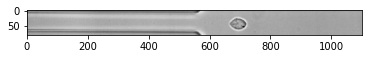

In [6]:
plt.figure()
plt.imshow(tracked_ds.dataset["image"][0], cmap='gray')
plt.show()

Define the regions of the channel. The included regions are inlet, channel, outlet and multiple constrictions. Here an example how to define the channel in the example dataset contains the inlet and the channel but not the outlet (default setting):

In [7]:
my_metadata = {"inlet": True,
               "channel": True,
               "outlet": False}

tracked_ds.set_tracking_metadata(my_metadata)

In [8]:
tracked_ds.print_tracking_metadata()

{'inlet': True,
 'channel': True,
 'outlet': False,
 'multiple_constrictions': False,
 'n_constrictions': 'auto',
 'flow_direction': 'left',
 'tolerance_window': 25,
 'channel_regions': [[0, 10]],
 'channel_x_min': 0,
 'channel_x_max': 10}

Define the flow direction. The options are `'right'` and `'left'` (default) which indicates flow __to__ the left.

In [9]:
# redundant here because this is the default value. You only need to change this if your samples flow to the right.
tracked_ds.set_tracking_metadata({"flow_direction": "left"})

### Define the channel start and end

To properly assign a time-stamp to an object event, the algorithm needs to the position zero which we define as the start and/or end of the channel region. `dctrack` can find these positions automatically, if they are apparent from the image or the user can set them manually either by entering the values or by selecting the channel region in the image.

#### Automatic channel detection

In [10]:
tracked_ds.set_channel_values_auto()
# print out the newly found tracking metadata
tracked_ds.print_tracking_metadata()

{'inlet': True,
 'channel': True,
 'outlet': False,
 'multiple_constrictions': False,
 'n_constrictions': 'auto',
 'flow_direction': 'left',
 'tolerance_window': 25,
 'channel_regions': [[0, 567]],
 'channel_x_min': 0,
 'channel_x_max': 567}

Plot the found positions in the ROI image:

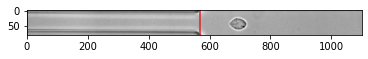

In [11]:
# now that the "channel_regions" have been set we can use the `plot_channel_regions` method
tracked_ds.plot_channel_regions()   # first region won't display because it's at 0

#### Manually setting channel values

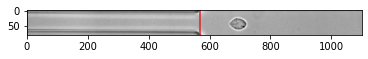

In [12]:
tracked_ds.set_channel_values_manual(x_min=0, x_max=567)

tracked_ds.plot_channel_regions()   # first region won't display because it's at 0

#### Selecting the channel region from the image:

A pop-up will open where you can use two sliders to define the region of the channel.

To create the gui, you need to create a TrackingSession object and GUI-app first

<img src="select_channel_gui_example.png" alt="Drawing" width="800"/>
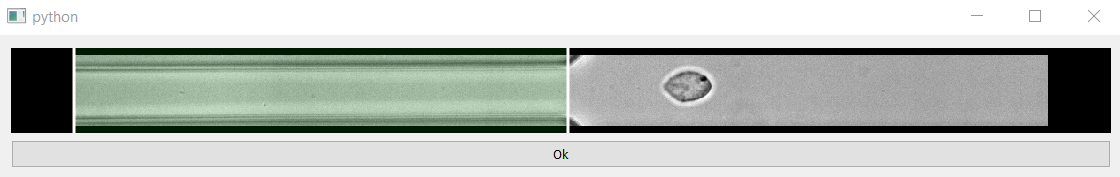

In [13]:
session = dctrack.TrackingSession()
app = session.get_app()
tracked_ds.set_channel_values_gui(app)

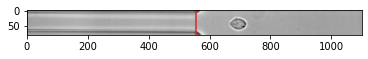

In [14]:
tracked_ds.plot_channel_regions()   # first region won't display because it's at 0

This can be called again, if the channel regions are not correct:

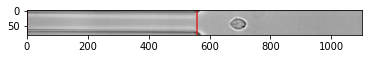

In [15]:
tracked_ds.set_channel_values_gui(app)
tracked_ds.plot_channel_regions()

#### Setting a tracking tolerance window

The object tracking predicts where an object from the previous frame will be located in the next frame within a certain tolerance that is defined by $\pm$&nbsp;`tolerance_window` in µm (default is 25 µm).

In [16]:
tracked_ds.set_tracking_metadata({"tolerance_window": 35})

### Tracking

With the preset parameters we can now track the dataset.

In [17]:
tracked_ds.track() # the RankWarning is expected

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\velocity_curve.py:180: RankWarning: Polyfit may be poorly conditioned
  poly_inlet = velocity_fit_poly(x_in_inlet, v_in_inlet)


Tracking in progress:   0%|          | 0/302 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing times after 189.50498077168177 µm:   0%|          | 0/15 [00:00<?, ?it/s]

Computing times after 372.8999853134155 µm:   0%|          | 0/15 [00:00<?, ?it/s]

The dataset now contains additional features that where assigned after tracking:

In [18]:
print(list(tracked_ds.dataset._usertemp.keys()))

['object_number', 'prediction_zone_start', 'prediction_zone_end', 'time_channel', 'velocity', 'time_inlet']


Find the unique object numbers:

In [19]:
unique_object_numbers = np.unique(ds['object_number'])
print(unique_object_numbers)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


You can grab the events belonging to the same objects with the 'get_object' function:

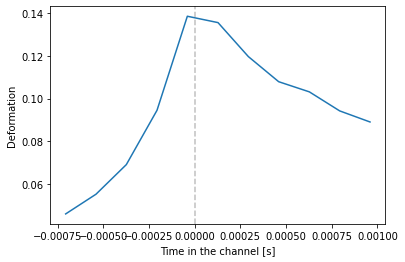

In [20]:
tr_object = tracked_ds.get_object(1)

plt.figure()
plt.plot(tr_object['time_channel'], tr_object['deform'])
plt.axvline(0, c='gray', ls='--', alpha=.5)
plt.xlabel('Time in the channel [s]')
plt.ylabel('Deformation')
plt.show()

Iterate over all objects:

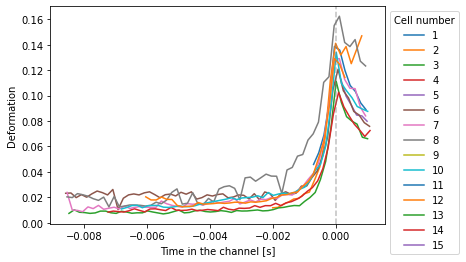

In [21]:
plt.figure()
for ii in unique_object_numbers:
    tr_object = tracked_ds.get_object(ii)
    plt.plot(tr_object['time_channel'], tr_object['deform'], label=str(int(ii)))
    
plt.axvline(0, c='gray', ls='--', alpha=.5)
plt.xlabel('Time in the channel [s]')
plt.ylabel('Deformation')
plt.legend(title="Cell number", loc='upper left', bbox_to_anchor=[1,1])
plt.show()

### Export the tracked datasets

Datasets can be exported to save the tracking results for further analysis. The exported file is in .rtdc or .hdf5 format and contains all features of the original dataset + the new tracking features and tracking metadata. To limit the size of the exported files, in the default setting only scalar features are exported.

In [22]:
export_path = "example_results_export_hdf5.rtdc"
tracked_ds.export_tracked_dataset_as_hdf5(export_path, override=True)

#### You can load the exported files either with `dctrack` or `dclab`

In [23]:
tracked_ds_import = dctrack.track.TrackedDataSet(export_path)
print('object_number' in tracked_ds_import.dataset.features)

True


In [24]:
ds_import = dclab.new_dataset(export_path)
print('object_number' in ds_import.features)

True


### Writing a video of the tracking results

To get an overview how well the tracking worked, the user can get a video of the tracking results (.avi file).

With the `draw_zones` option also the used prediction zones of the objects, the region within the tolerance window, will be plotted.

In [25]:
video_path = 'example_video.avi'
tracked_ds.write_video(save_path=video_path, first_frame=0, last_frame=500,
                       draw_zones=True)

Writing video:   0%|          | 0/302 [00:00<?, ?it/s]

It is also possible to write a video from an exported file that only contains the scalar features, when the user points to the location of the original rtdc file that was used for tracking:

In [26]:
dataset_original = dclab.new_dataset(rtdc_path)
video_path_scalar = 'example_video_scalar_export.avi'

dctrack.video.video_write_from_scalar_export(ds_import, dataset_original,
                                             first_frame=0, last_frame=500,
                                             save_path=video_path_scalar,
                                             draw_zones=True)

Writing video:   0%|          | 0/302 [00:00<?, ?it/s]

# Quick use case for simple channel geometry at RT-DC inlet

The defaults of the package are optimized for the use case of tracking cells at the inlet of an RT-DC channel. The code can be simplified to a few lines for this case:

In [27]:
tracked_ds = dctrack.track.TrackedDataSet(rtdc_path)
tracked_ds.set_channel_values_auto()
tracked_ds.track()

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\velocity_curve.py:180: RankWarning: Polyfit may be poorly conditioned
  poly_inlet = velocity_fit_poly(x_in_inlet, v_in_inlet)


Tracking in progress:   0%|          | 0/302 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/15 [00:00<?, ?it/s]

Computing times after 192.21299242973328 µm:   0%|          | 0/15 [00:00<?, ?it/s]

Computing times after 372.8999853134155 µm:   0%|          | 0/15 [00:00<?, ?it/s]

#### Plot the results

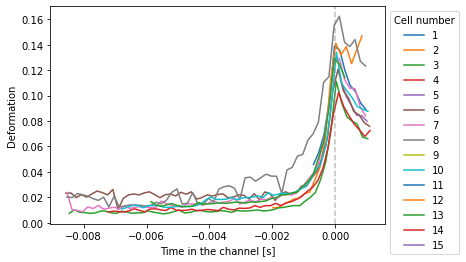

In [28]:
unique_object_numbers = np.unique(tracked_ds.dataset['object_number'])

plt.figure()
for ii in unique_object_numbers:
    tr_object = tracked_ds.get_object(ii)
    plt.plot(tr_object['time_channel'], tr_object['deform'], label=str(int(ii)))
    
plt.axvline(0, c='gray', ls='--', alpha=.5)
plt.xlabel('Time in the channel [s]')
plt.ylabel('Deformation')
plt.legend(title="Cell number", loc='upper left', bbox_to_anchor=[1,1])
plt.show()

## Use filters on the tracked dataset

The object tracking is not always perfect and the user might want to exclude objects that were tracked insufficiently or even incorrectly. The filtering can be done with the `TrackedDataSet.filter()` function.
Currently three object filters are implemented:

- Does the object move against the flow at some point
- Does the object cover a certain distance
- How many events does the tracked object contain

Which filters should be used are attributes of the `TrackedDataSet` class:

In [29]:
# set the filters that should be used on the data
tracked_ds.filter_obj_distance = False
tracked_ds.filter_obj_n_events = True
tracked_ds.filter_backward_movement = True

Calling the `.filter()` without further arguments will apply the `dataset.apply_filter()` function of dclab. The filter array can than be grabbed from `tracked_ds.dataset` and be used to filter for features as follows:

In [30]:
# max_back_movement defines the maximum distance an object is allowed to move backward in um
tracked_ds.filter(min_events=3, max_events=10000, max_back_movement=0)
print(tracked_ds.dataset.filter.all)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [31]:
filt = tracked_ds.dataset.filter.all
print(len(tracked_ds.dataset['deform']), len(tracked_ds.dataset['deform'][filt]))

448 290


Creating a new dataset from the filtered tracked dataset, will then return the filtered data only:

In [32]:
ds_filtered = dclab.new_dataset(tracked_ds.dataset)
print(len(tracked_ds.dataset['deform']), len(ds_filtered['deform']))

448 290


The filter array or filtered dataset can also be directly returned from the filter function:

In [33]:
filter_array = tracked_ds.filter(min_events=3, max_events=10000, max_back_movement=0, return_filter=True)
print(len(tracked_ds.dataset['deform']), len(tracked_ds.dataset['deform'][filter_array]))

448 290


In [34]:
ds_filtered2 = tracked_ds.filter(min_events=3, max_events=10000, max_back_movement=0, return_filtered_ds=True)
print(len(tracked_ds.dataset['deform']), len(ds_filtered2['deform']))

448 290


In [35]:
filter_array, ds_filtered3 = tracked_ds.filter(min_events=3, max_events=10000, max_back_movement=0,
                                               return_filter=True, return_filtered_ds=True)
print(len(tracked_ds.dataset['deform']), len(tracked_ds.dataset['deform'][filter_array]))
print(len(tracked_ds.dataset['deform']), len(ds_filtered2['deform']))

448 290
448 290


Classical filtering like in `dclab` is also supported with the `.filter_feature()` function:

In [36]:
deform_filtered = tracked_ds.filter_feature("deform", 0, 0.05)
print(len(deform_filtered))

227


In [38]:
tr_ds_filter = tracked_ds.dataset.filter.all
np.array_equal(deform_filtered, tracked_ds.dataset['deform'][tr_ds_filter])

True